# Implement the EGO algorithm

In this example, we analyse the EGO algorithm and see its behaviour step by step.

## Acknowledgements

We thank Romain Espoeys (CEA) for sharing his script.

In [1]:
import numpy as np
import openturns as ot
import openturns.viewer as otv
import openturns.experimental as otexp

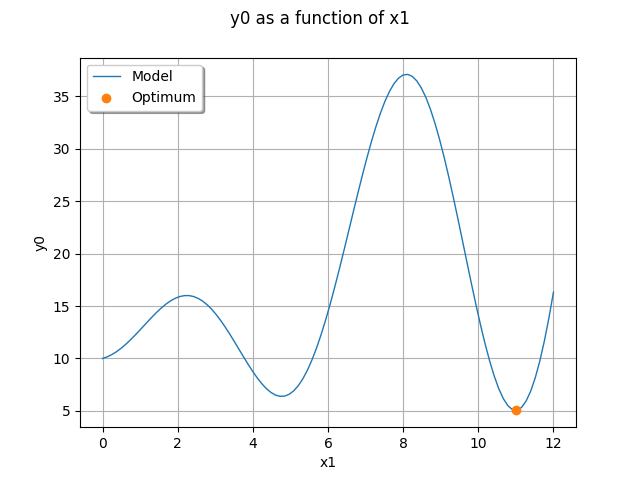

In [ ]:
ot.RandomGenerator.SetSeed(0)

ot.ResourceMap.SetAsString("GaussianProcessFitter-LinearAlgebra", "LAPACK")
ot.Log.Show(ot.Log.NONE)

dimension = 1

exact_x_min = 10.9911
exact_y_min = 5.04933

bounds = ot.Interval([0.0] * dimension, [12.0] * dimension)

model = ot.SymbolicFunction(["x1"], ["10.0 + x1 + x1^2 / 20 + 2.0 * x1 * sin(x1)"])
model = ot.MemoizeFunction(model)

graph = model.draw(0.0, 12.0, 100)
graph.setLegends(["Model"])
cloud = ot.Cloud([exact_x_min], [exact_y_min])
cloud.setLegend("Optimum")
cloud.setPointStyle("circle")
graph.add(cloud)
graph.setLegendPosition("topleft")
graph.setColors(ot.Drawable.BuildDefaultPalette(2))
graph

There is only one global optimum, but three local minimums. We see that the global optimum is near $x\approx 11$, where the minimum function value is $y\approx 5$. The interesting fact is that the value $y\approx 7$ is reached for a very different input at $x\approx 5$. Another local optimum can be seen on the extreme left, at $x=0$ where the function value is $y=10$. The purpose of this test case is to see how the EGO algorithm can manage these local minimums and find the global solution.

Create the training DOE.

In [3]:
distribution = ot.JointDistribution([ot.Uniform(0.0, 12.0)] * dimension)

training_sample_size = 5
x_train = ot.LHSExperiment(distribution, training_sample_size, False, True).generate()
y_train = model(x_train)

x_train

,X0
0,10.43294
1,4.726615
2,7.009631
3,1.207296
4,7.351695


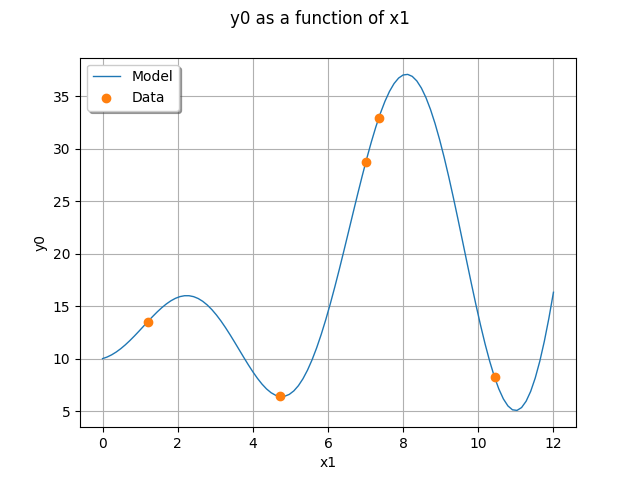

In [4]:
graph = model.draw(0.0, 12.0, 100)
graph.setLegends(["Model"])
cloud = ot.Cloud(x_train, y_train)
cloud.setLegend("Data")
cloud.setPointStyle("circle")
graph.add(cloud)
graph.setColors(ot.Drawable.BuildDefaultPalette(2))
graph.setLegendPosition("topleft")
graph

Create a test sample. This will be used to evaluate the EI criterion on a grid. In a real study, we would use an optimization algorithm, but for this demo, this naive implementation will do the job.

In [5]:
xmin = 0.0
xmax = 12.0
test_sample_size = 200
step = (xmax - xmin) / (test_sample_size - 1)
myRegularGrid = ot.RegularGrid(xmin, step, test_sample_size)
x_test = myRegularGrid.getVertices()

We now define the Kriging parameters, that is, the trend and the covariance model.

In [6]:
dimension = 1
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.MaternModel([1.0] * dimension, 2.5)  # Matern_5/2

The following class `ExpectedImprovementEvaluation` defines the EI criterion. It allows to get the criterion as a `Function` which is easy to plot.

In [ ]:
class ExpectedImprovementEvaluation(ot.OpenTURNSPythonFunction):
    """Defines the expected improvement criterion."""

    def __init__(self, optimalValue, gpr_result):
        """
        Create a ExpectedImprovementEvaluation.

        Parameters
        ----------
        optimalValue : float
            The best value so far.
        krigingResult : ot.GaussianProcessRegressiongResult
            The kriging metamodel.

        Returns
        -------
        None.
        """
        metamodel = gpr_result.getMetaModel()
        inputDimension = metamodel.getInputDimension()
        super(ExpectedImprovementEvaluation, self).__init__(inputDimension, 1)
        self.optimalValue = optimalValue
        self.gpr_result = gpr_result

    def _exec(self, x):
        """
        Evaluate the EI function at point x.

        Parameters
        ----------
        x : ot.Point
            The input point.

        Returns
        -------
        expectedImprovement : ot.Point(1)
            The value of the expected improvement.

        """
        conditional = otexp.GaussianProcessConditionalCovariance(self.gpr_result)
        mx = conditional.getConditionalMean(x)[0]
        fmMk = self.optimalValue - mx
        sk2 = conditional.getConditionalMarginalVariance(x)
        sk2 = max(sk2, 0.0)
        sk = np.sqrt(sk2)
        if sk == 0.0:
            ei = 0.0
        else:
            ratio = fmMk / sk
            ei = fmMk * ot.DistFunc.pNormal(ratio) + sk * ot.DistFunc.dNormal(ratio)
        return [ei]

Perform one single step of the EGO algorithm.

In [8]:
# Evaluate the DOE minimum
y_min = y_train.getMin()[0]
# Kriging
fitter = otexp.GaussianProcessFitter(x_train, y_train, covarianceModel, basis)
fitter.run()
fitter_result = fitter.getResult()
gpr = otexp.GaussianProcessRegression(fitter_result)
gpr.run()
gpr_result = gpr.getResult()
krigeageMM = gpr_result.getMetaModel()
y_test_MM = krigeageMM(x_test)
# Evaluate Expected Improvement
evaluationEI = ExpectedImprovementEvaluation(y_min, gpr_result)
functionEI = ot.Function(evaluationEI)
y_test_EI = functionEI(x_test)
# Calculate argmax(EI) and get the value of x_new
ymax_EI = y_test_EI.getMax()
i = y_test_EI.find(ymax_EI)
x_new = x_test[i]
# Calculate y_new = fonction(x_new)
y_new = model(x_new)
# Add this new point to the DOE
x_train.add(x_new)
y_train.add(y_new)

<class 'openturns.experimental.GaussianProcessRegressionResult'>


In [9]:
# Get (x_opt,y_opt) the optimal point
y_opt = y_train.getMin()
i = y_train.find(y_opt)
x_opt = x_train[i]
print("x_opt = ", x_opt)
print("y_opt = ", y_opt)

x_opt =  [4.72662]
y_opt =  [6.39139]


Plot.

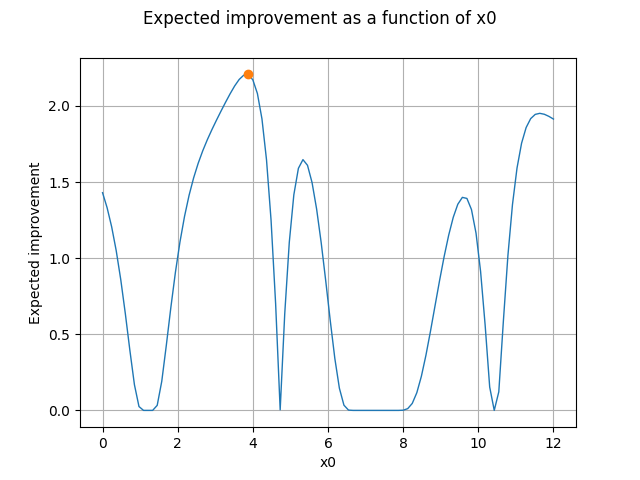

In [10]:
functionEI.setInputDescription(krigeageMM.getInputDescription())
functionEI.setOutputDescription(["Expected improvement"])
graph = functionEI.draw(0.0, 12.0, 100)
cloud = ot.Cloud([x_new], [ymax_EI])
cloud.setPointStyle("circle")
graph.add(cloud)
graph.setColors(ot.Drawable.BuildDefaultPalette(2))
graph

We see that the criterion is maximized near the point $x=4$ approximately. 

In [11]:
def plot_data_train(x_train, y_train):
    cloud = ot.Cloud(x_train, y_train)
    cloud.setColor("red")
    cloud.setPointStyle("circle")
    cloud.setLegend("DOE")
    return cloud

In [12]:
def plot_data_ego(x_opt, y_opt):
    graph_ego = ot.Cloud(x_opt, y_opt)
    graph_ego.setPointStyle("diamond")
    graph_ego.setColor("forestgreen")
    graph_ego.setLegend("EGO")
    return graph_ego

In [13]:
def plot_data_test(x_test, y_test):
    graphF = ot.Curve(x_test, y_test)
    graphF.setLegend("Function")
    graphF.setColor("black")
    graphF.setLineStyle("dashed")
    return graphF

In [14]:
def plot_data_kriging(x_test, y_test_MM):
    graphK = ot.Curve(x_test, y_test_MM)
    graphK.setColor("blue")
    graphK.setLegend("Kriging MM")
    return graphK

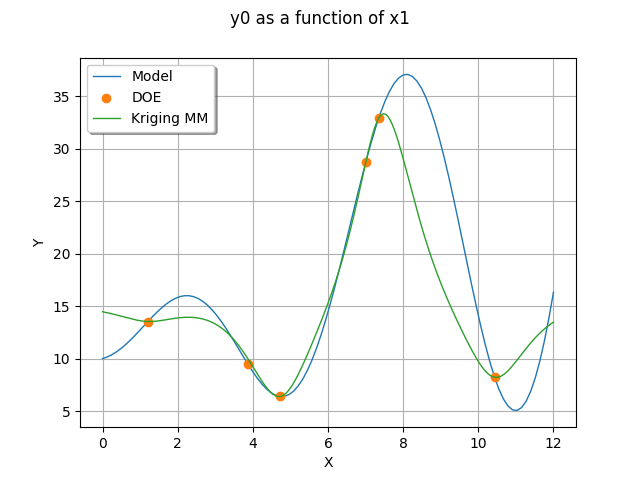

In [15]:
graph = model.draw(0.0, 12.0, 100)
graph.setLegends(["Model"])
graph.add(plot_data_train(x_train, y_train))
graph.add(plot_data_kriging(x_test, y_test_MM))
graph.setAxes(True)
graph.setXTitle("X")
graph.setYTitle("Y")
graph.setLegendPosition("topleft")
graph.setColors(ot.Drawable.BuildDefaultPalette(3))
graph

In [16]:
def linearSample(xmin, xmax, npoints):
    """Returns a sample created from a regular grid
    from xmin to xmax with npoints points."""
    step = (xmax - xmin) / (npoints - 1)
    rg = ot.RegularGrid(xmin, step, npoints)
    vertices = rg.getVertices()
    return vertices

In [17]:
def full_to_alpha_color(color, alpha=128):
    """
    Convert a full color to a given alpha color.

    Parameters
    ----------
    color : str
        The Hex color.
    alpha : int, in [0, 256]
        The alpha channel of the [R, G, B, A] color space

    Returns
    -------
    alpha_color : str
        The Hex color.
    """
    [r, g, b] = ot.Drawable.ConvertToRGB(color)
    alpha_color = ot.Drawable.ConvertFromRGBA(r, g, b, alpha)
    return alpha_color

In [18]:
def plot_kriging_bounds(
    gpr_result, x_test, color, alphaLevel=0.95, alphaTransparency=64
):
    """
    Plot normal confidence bounds of a kriging

    Parameters
    ----------
    gpr_result : ot.KrigingResult
        The kriging
    x_test : ot.Sample
        The x testing points
    color : hex str
        The color
    alphaLevel : float, in [0, 1]
        The confidence level
    alphaTransparency : int, in {0, ..., 255}
        The transparency

    Returns
    -------
    boundsPoly : ot.PolygonArray
        The colored area.
    """
    conditional = otexp.GaussianProcessConditionalCovariance(gpr_result)
    covGrid = conditional.getConditionalMarginalVariance(x_test)
    krigeageMM = gpr_result.getMetaModel()
    y_test_MM = krigeageMM(x_test)
    n_test = x_test.getSize()
    N = ot.Normal()
    bilateralCI = N.computeBilateralConfidenceInterval(alphaLevel)
    quantileAlpha = bilateralCI.getUpperBound()[0]
    conditionalStDev = ot.Sample([[np.sqrt(covGrid[i, 0])] for i in range(n_test)])
    dataLower = [
        [y_test_MM[i, 0] - quantileAlpha * conditionalStDev[i, 0]]
        for i in range(n_test)
    ]
    dataUpper = [
        [y_test_MM[i, 0] + quantileAlpha * conditionalStDev[i, 0]]
        for i in range(n_test)
    ]
    boundsPoly = ot.Polygon.FillBetween(x_test, dataLower, dataUpper)
    boundsPoly.setLegend(f"{alphaLevel * 100} bounds")
    boundsPoly.setColor(full_to_alpha_color(color, alphaTransparency))
    return boundsPoly

In [19]:
def plotMyBasicKriging(gpr_result, model, xMin, xMax, X, Y, level=0.95):
    """
    Given a kriging result, plot the data, the kriging metamodel
    and a confidence interval.
    """
    samplesize = X.getSize()
    meta = gpr_result.getMetaModel()
    graphKriging = meta.draw(xMin, xMax)
    graphKriging.setLegends(["Kriging"])
    # Create a grid of points and evaluate the function and the kriging
    nbpoints = 50
    xGrid = linearSample(xMin, xMax, nbpoints)
    yFunction = model(xGrid)
    yKrig = meta(xGrid)
    # Compute the conditional covariance
    conditional = otexp.GaussianProcessConditionalCovariance(gpr_result)
    conditionalVariance = conditional.getConditionalMarginalVariance(xGrid)
    conditionalSigma = np.sqrt(conditionalVariance)
    # Compute the quantile of the Normal distribution
    alpha = 1 - (1 - level) / 2
    quantileAlpha = ot.DistFunc.qNormal(alpha)
    # Graphics of the bounds
    dataLower = ot.Point(
        [yKrig[i, 0] - quantileAlpha * conditionalSigma[i, 0] for i in range(nbpoints)]
    )
    dataUpper = ot.Point(
        [yKrig[i, 0] + quantileAlpha * conditionalSigma[i, 0] for i in range(nbpoints)]
    )
    # Compute the Polygon graphics
    palette = ot.Drawable.BuildDefaultPalette(10)
    boundsPoly = plot_kriging_bounds(gpr_result, xGrid, palette[4])
    # Validate the kriging metamodel
    mmv = ot.MetaModelValidation(yFunction, meta(xGrid))
    Q2 = mmv.computeR2Score()[0]
    # Plot the function
    graphFonction = ot.Curve(xGrid, yFunction)
    graphFonction.setLineStyle("dashed")
    graphFonction.setLineWidth(2)
    graphFonction.setLegend("Function")
    # Draw the X and Y observed
    cloudDOE = ot.Cloud(X, Y)
    cloudDOE.setPointStyle("circle")
    cloudDOE.setLegend("Data")
    # Assemble the graphics
    graph = ot.Graph()
    graph.add(boundsPoly)
    graph.add(graphFonction)
    graph.add(cloudDOE)
    graph.add(graphKriging)
    graph.setLegendPosition("bottomright")
    graph.setAxes(True)
    graph.setGrid(True)
    graph.setTitle("Size = %d, Q2=%.2f%%" % (samplesize, 100 * Q2))
    graph.setXTitle("X")
    graph.setYTitle("Y")
    return graph

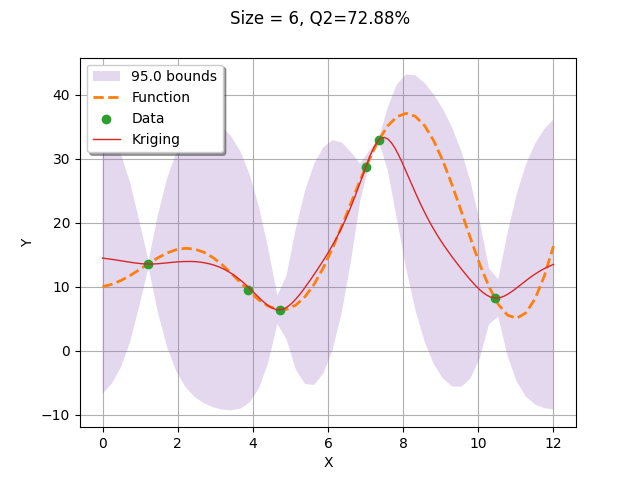

In [20]:
graph = plotMyBasicKriging(
    gpr_result,
    model,
    0.0,
    12.0,
    x_train,
    y_train,
)
palette = ot.Drawable.BuildDefaultPalette(5)
graph.setLegendPosition("topleft")
graph

The significant region of the domain is the vertical area where the 95% bounds are lowest. There are several regions which are good candidate for optimization:
* near $x=0$,
* near $x=3$,
* near $x=9$,
* near $x=12$.

In order to see how the algorithm performs at each step, we create the following `EGOStepwiseAlgorithm` class.

In [21]:
class EGOStepwiseAlgorithm:
    """A stepwise EGO algorithm."""

    def __init__(self, problem, gpr_result, x_test):
        """
        Create a stepwise EGO algorithm.

        Parameters
        ----------
        problem : ot.OptimizationProblem
            The optimization problem to be solved.
        gpr_result : ot.KrigingResult
            A kriging.
        x_test : ot.Sample
            The sample used to get the minimum of the EI criterion.
        """
        self.problem = problem
        self.model = problem.getObjective()
        self.gpr_result = gpr_result
        self.x_train = gpr_result.getInputSample()
        self.y_train = gpr_result.getOutputSample()
        self.covarianceModel = gpr_result.getCovarianceModel()
        self.basis = gpr_result.getBasis()
        self.x_test = x_test
        self.y_min = self.y_train.getMin()[0]
        i = self.y_train.find([self.y_min])
        self.x_min = self.x_train[i]

    def step(self):
        """
        Performs one single step of the algorithm.

        Parameters
        ----------
        None

        Returns
        -------
        x_new : ot.Point
            The new input point identified by the EGO algorithm.
        """
        # Kriging
        fitter = otexp.GaussianProcessFitter(
            self.x_train, self.y_train, self.covarianceModel, self.basis
        )
        fitter.run()
        fitter_result = fitter.getResult()
        gpr = otexp.GaussianProcessRegression(fitter_result)
        gpr.run()
        self.gpr_result = gpr.getResult()
        # Evaluate Expected Improvement
        evaluationEI = ExpectedImprovementEvaluation(self.y_min, self.gpr_result)
        functionEI = ot.Function(evaluationEI)
        y_test_EI = functionEI(x_test)
        # Calculate argmax(EI) and get the value of x_new
        y_max_EI = y_test_EI.getMax()
        i = y_test_EI.find(y_max_EI)
        x_new = x_test[i]
        # Calculate y_new = fonction(x_new)
        y_new = model(x_new)
        # Add this new point to the DOE
        self.x_train.add(x_new)
        self.y_train.add(y_new)
        # Update the minimum
        self.y_min = self.y_train.getMin()[0]
        i = self.y_train.find([self.y_min])
        self.x_min = self.x_train[i]
        return x_new

    def plot(self):
        """
        Plot the current kriging metamodel.

        Parameters
        ----------
        None

        Returns
        -------
        graph : ot.Graph
            Plots the model, the kriging and the data.
        """
        bounds = self.problem.getBounds()
        lowerBound = bounds.getLowerBound()
        upperBound = bounds.getUpperBound()
        graph = plotMyBasicKriging(
            self.gpr_result,
            self.model,
            lowerBound[0],
            upperBound[0],
            self.x_train,
            self.y_train,
        )
        cloud = ot.Cloud([self.x_min], [[self.y_min]])
        cloud.setLegend("Opt")
        cloud.setPointStyle("square")
        graph.add(cloud)
        return graph

    def get_xmin(self):
        """
        Return the best input point.

        Parameters
        ----------
        None

        Returns
        -------
        x_min : ot.Point
            The best input point so far.
        """
        return self.x_min

    def get_ymin(self):
        """
        Return the best input point.

        Parameters
        ----------
        None

        Returns
        -------
        y_min : ot.Point
            The best output value so far.
        """
        return self.y_min

The class is based on an `OptimizationProblem` which uses the model as the objectif and the bounds of the domain.

In [22]:
problem = ot.OptimizationProblem()
problem.setObjective(model)
problem.setBounds(bounds)

Let's go for EGO!

In [23]:
stepwiseEGO = EGOStepwiseAlgorithm(problem, gpr_result, x_test)

<class 'openturns.experimental.GaussianProcessRegressionResult'>
New point: [3.8593]
<class 'openturns.experimental.GaussianProcessRegressionResult'>
New point: [11.6985]
<class 'openturns.experimental.GaussianProcessRegressionResult'>
New point: [5.30653]
<class 'openturns.experimental.GaussianProcessRegressionResult'>
New point: [0]
<class 'openturns.experimental.GaussianProcessRegressionResult'>
New point: [10.9749]
<class 'openturns.experimental.GaussianProcessRegressionResult'>
New point: [2.59296]
<class 'openturns.experimental.GaussianProcessRegressionResult'>
New point: [10.8543]
<class 'openturns.experimental.GaussianProcessRegressionResult'>
New point: [11.0352]
<class 'openturns.experimental.GaussianProcessRegressionResult'>
New point: [4.40201]
<class 'openturns.experimental.GaussianProcessRegressionResult'>
New point: [0.482412]


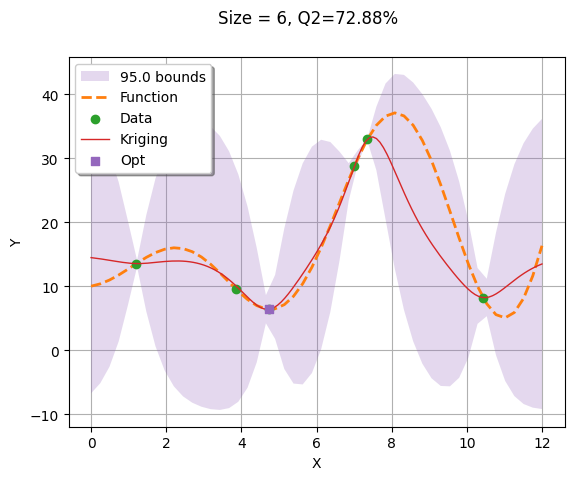

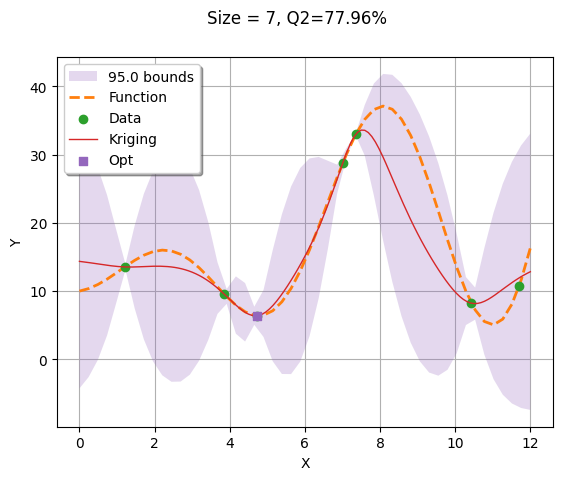

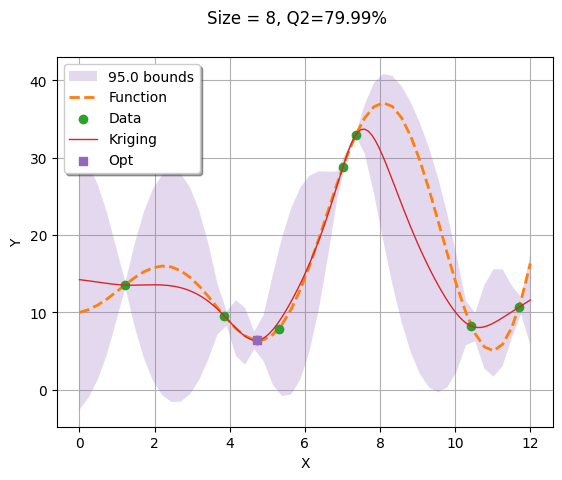

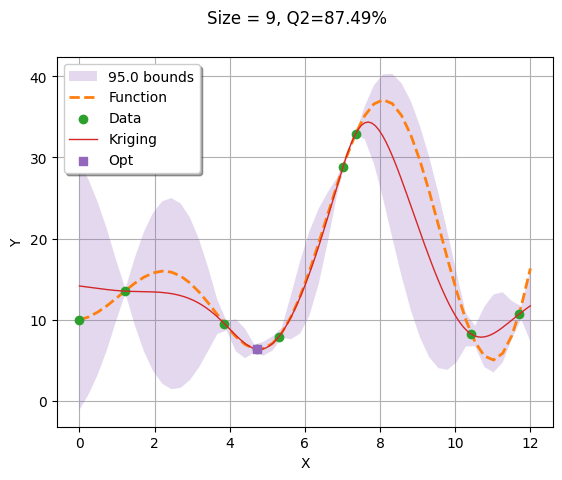

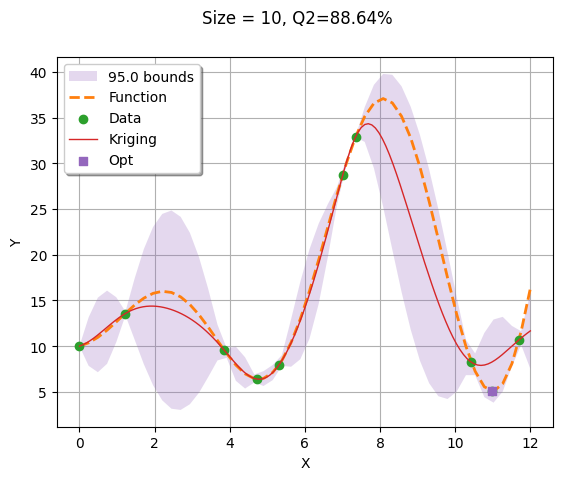

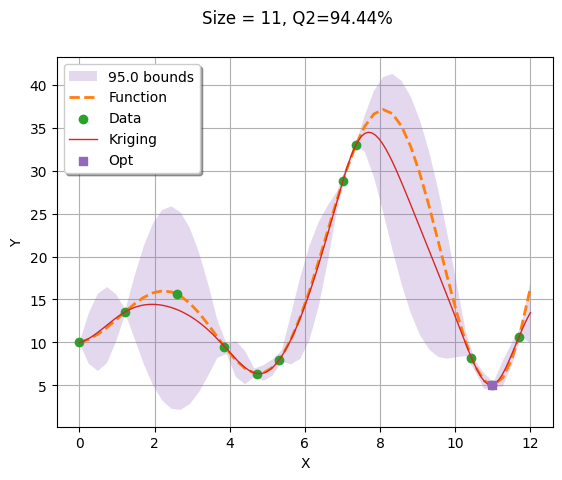

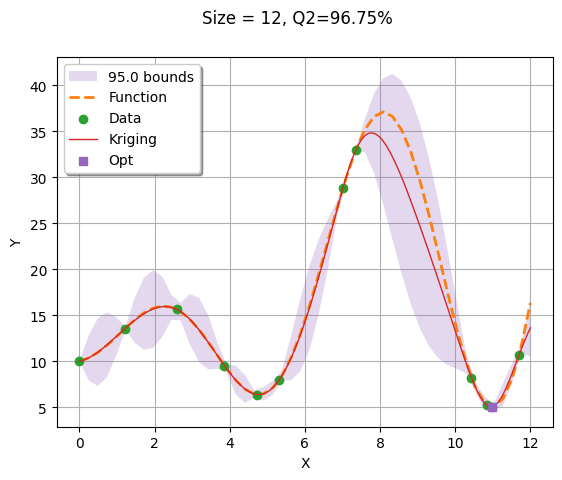

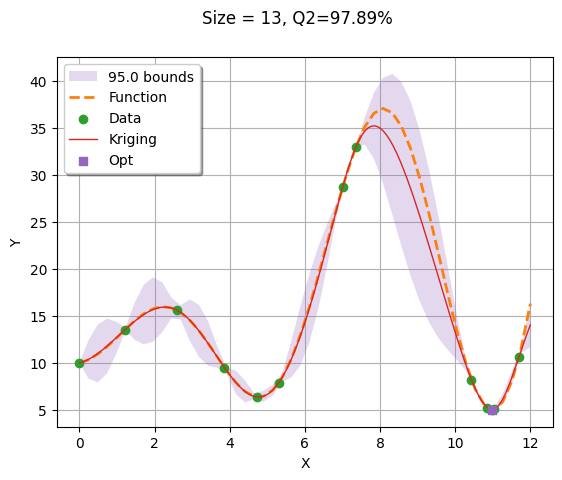

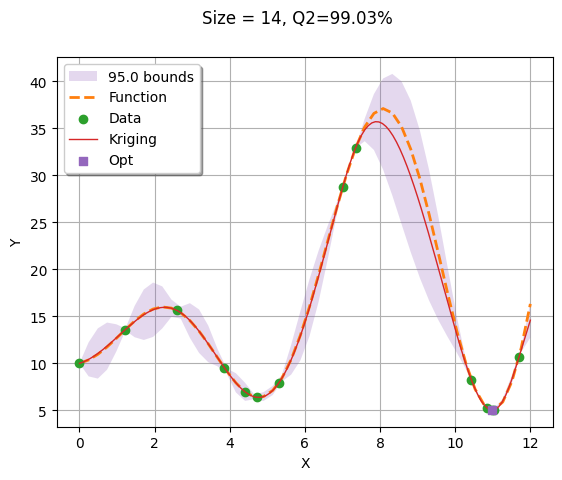

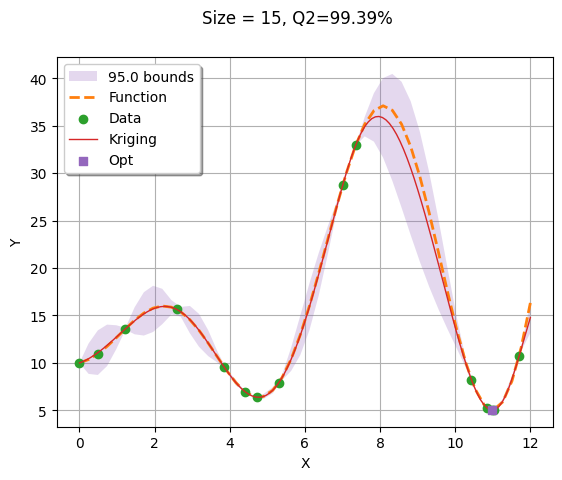

In [24]:
graph = stepwiseEGO.plot()
for iteration in range(10):
    x_new = stepwiseEGO.step()
    print("New point:", x_new)
    graph = stepwiseEGO.plot()
    graph.setLegendPosition("topleft")
    otv.View(graph)

There are several comments on the figure and its dynamic.
* Notice how the computed optimum jumps from $x\approx 5$ to $x\approx 11$ from iteration 9 to iteration 10. This shows how the algorithm can manage global optimization: it does not get stuck to a local optimum.
* After 15 iterations, the algorithm has added several points where the optimum could be found, e.g. near $x=0$, near $x=5$ and near $x=11$, and almost none in the regions where a minimum cannot be found, e.g. near $x=2$ and $x=8$. For these two regions, the uncertainty in the metamodel value is still large, but this does not matter because the chance of finding an optimum is reduced in these areas.

In [25]:
x_min = stepwiseEGO.get_xmin()
y_min = stepwiseEGO.get_ymin()
print("X min= %.2f" % (x_min[0]))
print("Y min= %.3f" % (y_min))

X min= 10.97
Y min= 5.052


In [26]:
print("X min exact = %.2f" % (exact_x_min))
print("Y min exact = %.3f" % (exact_y_min))

X min exact = 10.99
Y min exact = 5.049


Compared to the exact solution, we see that the EGO algorithm is already very close to the exact solution of this difficult optimization problem. 